In [51]:
import os
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import time
import math

from IPython import display

In [52]:
import urllib
categories = [line.rstrip(b'\n') for line in urllib.request.urlopen('https://raw.githubusercontent.com/googlecreativelab/quickdraw-dataset/master/categories.txt')]
print(categories[:10])
category = 'candle'

[b'aircraft carrier', b'airplane', b'alarm clock', b'ambulance', b'angel', b'animal migration', b'ant', b'anvil', b'apple', b'arm']


In [53]:
# Creates a folder to download the original drawings into.
# We chose to use the numpy format : 1x784 pixel vectors, with values going from 0 (white) to 255 (black). We reshape them later to 28x28 grids and normalize the pixel intensity to [-1, 1]

if not os.path.isdir('npy_files'):
    os.mkdir('npy_files')
    
url = f'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/{category}.npy'  
urllib.request.urlretrieve(url, f'npy_files/{category}.npy')

images = np.load(f'npy_files/{category}.npy')
#print(f'{len(images)} images to train on')

# You can limit the amount of images you use for training by setting :
train_images = images[:30016]
print(f'{len(train_images)} train images to train on')
# You should also define a samller subset of the images for testing..
test_images = images[30016:31040]
print(f'{len(test_images)} test images to train on')
# Notice that this to numpy format contains 1x784 pixel vectors, with values going from 0 (white) to 255 (black). We reshape them later to 28x28 grids and normalize the pixel intensity to [-1, 1]

30016 train images to train on
1024 test images to train on


In [54]:
import tensorflow as tf
#turn into tf Dataset
#reshape into 28,28,1 images
#add label 'candle' to each image

def preprocess(data):
    data = data.tolist()
    data = tf.data.Dataset.from_tensor_slices((data))
    data = data.map(lambda img: (tf.cast(img, tf.float32)))
    data = data.map(lambda img: ((img/128.)-1.))
    data = data.map(lambda img: (tf.reshape(img, [28,28,1])))
    #data = data.map(lambda img: (img, 'candle'))
    data = data.shuffle(1000)
    data = data.batch(32)
    data = data.prefetch(20)

    return data

In [55]:
train_ds = preprocess(train_images)
test_ds = preprocess(test_images) 

print(type(test_ds))

<class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>


In [56]:
from tensorflow.python.ops.gen_dataset_ops import FinalizeDataset
class Discriminator(tf.keras.Model):
    #The underlying idea of the discriminator is to perform
    #downsampling and then outputting a vector of probabilities indicating
    #whether the input was fake or real

    def __init__(self):
      
        super().__init__()

        self.optimizer = tf.keras.optimizers.Adam()
        self.metrics_list = [tf.keras.metrics.Mean(name="loss")]
        self.loss = tf.keras.losses.BinaryCrossentropy()

        self.layer1 = tf.keras.Sequential()
        self.layer1.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='valid', activation='relu')) 
        self.layer1.add(tf.keras.layers.LeakyReLU())
        self.layer1.add(tf.keras.layers.Dropout(0.2))
        
        self.layer2 = tf.keras.Sequential()
        self.layer2.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='valid', activation='relu')) 
        self.layer2.add(tf.keras.layers.LeakyReLU())
        self.layer2.add(tf.keras.layers.Dropout(0.2))
        
        self.flatten = tf.keras.layers.Flatten()
        self.out = tf.keras.layers.Dense(1, activation='sigmoid')
      
    @tf.function
    def call(self, x, training=False):
        x = self.layer1(x, training=training)
        x = self.layer2(x, training=training)
        x = self.flatten(x, training=training)
        x = self.out(x, training=training)

        return x

    def reset_metrics(self):
        for metric in self.metrics:
            metric.reset_states()
    
    @tf.function
    def train_step(self, data):
        return {m.name: m.result() for m in self.metrics}

    @tf.function
    def testn_step(self, data):
        return {m.name: m.result() for m in self.metrics}
        

In [57]:
class Generator(tf.keras.Model):
    """The generator takes a random point from the latent
    space6 and returns a generated image. The latent space comes as a 1d
    vector, so to receive a 2d image you need to reshape it. To increase the
    size, use upsampling techniques like Conv2DTranspose78. In the last layer,
    perform a convolution with 1 feature map and tanh activation. This will
    be the output image"""

    def __init__(self):
        super().__init__()

        
        self.optimizer = tf.keras.optimizers.Adam(0.0005)
        self.metrics_list = [tf.keras.metrics.Mean(name="loss")]
        self.loss = tf.keras.losses.BinaryCrossentropy()

        #model from tutorial
        self.reshape = tf.keras.Sequential()
        self.reshape.add(tf.keras.layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
        self.reshape.add(tf.keras.layers.Dropout(0.2))
        self.reshape.add(tf.keras.layers.BatchNormalization())
        self.reshape.add(tf.keras.layers.LeakyReLU())

        self.reshape.add(tf.keras.layers.Reshape((7, 7, 256)))
        #assert model.output_shape == (None, 7, 7, 256) 

        self.layer1 = tf.keras.Sequential()
        self.layer1.add(tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
        #assert model.output_shape == (None, 7, 7, 128)
        self.layer1.add(tf.keras.layers.Dropout(0.2))
        self.layer1.add(tf.keras.layers.BatchNormalization())
        self.layer1.add(tf.keras.layers.LeakyReLU())

        self.layer2 = tf.keras.Sequential()
        self.layer2.add(tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
        #assert model.output_shape == (None, 14, 14, 64)
        self.layer2.add(tf.keras.layers.Dropout(0.2))
        self.layer2.add(tf.keras.layers.BatchNormalization())
        self.layer2.add(tf.keras.layers.LeakyReLU())

        self.out = tf.keras.layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
        #assert model.output_shape == (None, 28, 28, 1)


        

    @tf.function  
    def call(self, x, training=False):
      
        x = self.reshape(x)   
        x = self.layer1(x, training=training)
        x = self.layer2(x, training=training)
        x = self.out(x)
        
        return x

    def reset_metrics(self):
        for metric in self.metrics:
            metric.reset_states()
    
    @tf.function
    def train_step(self, data):
        return {m.name: m.result() for m in self.metrics}

    @tf.function
    def testn_step(self, data):
        return {m.name: m.result() for m in self.metrics}
        


In [58]:
def train_step(generator, discriminator, real_data, gen_vis):
    training=True

    noise = tf.random.normal([32,100]) # noise vector for generator
    gen_t_fake_data = tf.ones((32,1)) # targets for fake images for generator & real images for discriminator
    dis_t_fake_data = tf.zeros((32,1)) # targets for fake images for discriminator

    # train discriminator on real images
    # forward and backwards pass
    with tf.GradientTape() as tape_dis1:
        pred_true = discriminator(real_data, training=training)
        loss_dis1 = discriminator.loss(gen_t_fake_data, pred_true)

    gradients_dis1 = tape_dis1.gradient(loss_dis1, discriminator.trainable_variables)
    discriminator.optimizer.apply_gradients(grads_and_vars=zip(gradients_dis1, discriminator.trainable_variables))

    discriminator.metrics[0].update_state(loss_dis1)

    # train generator and discriminator on fake images
    with tf.GradientTape() as tape_dis2:
        with tf.GradientTape() as tape_gen:

            # generate fake images and save them for visualization
            gen_x = generator(noise, training) 
            gen_vis.append(gen_x) # for visualizing sample images

            # let discriminator determine their status (real/fake)
            pred_fake = discriminator(gen_x, training=training)

            # compute losses for generator and discriminator
            # using the opposite targets
            loss_gen = generator.loss(gen_t_fake_data, pred_fake)
            loss_dis2 = discriminator.loss(dis_t_fake_data, pred_fake)
            #loss_dis = loss(tf.concat([dis_t_fake_data, gen_t_fake_data], 0), tf.concat([pred_fake, pred_true], 0))
            
    # backwards propagation for discriminator and generator
    gradients_dis2 = tape_dis2.gradient(loss_dis2, discriminator.trainable_variables)
    discriminator.optimizer.apply_gradients(grads_and_vars=zip(gradients_dis2, discriminator.trainable_variables))
    gradients_gen = tape_gen.gradient(loss_gen, generator.trainable_variables)
    generator.optimizer.apply_gradients(grads_and_vars=zip(gradients_gen, generator.trainable_variables))

    # update loss metric
    discriminator.metrics[0].update_state(loss_dis2)
    generator.metrics[0].update_state(loss_gen)
  
    # Return a dictionary mapping metric names to current value
    return ({m.name: m.result() for m in generator.metrics}, 
            {m.name: m.result() for m in discriminator.metrics}) 

In [59]:
def test_step(data, generator, discriminator):

    noise = tf.random.normal([32,100]) # noise vector for generator
    target_ones = tf.ones((32,1)) # targets for fake images for generator & real images for discriminator
    target_zeros = tf.zeros((32,1)) # targets for fake images for discriminator

    # real images in discriminator
    pred_true = discriminator(data, training=False)
    loss_dis1 = discriminator.loss(target_ones, pred_true)

    discriminator.metrics[0].update_state(loss_dis1)

    # generate fake images & put into discriminator
    gen_x = generator(noise, training=False) 
    pred_fake = discriminator(gen_x, training=False)
    loss_gen = generator.loss(target_ones, pred_fake)
    loss_dis2 = discriminator.loss(target_zeros, pred_fake)

    discriminator.metrics[0].update_state(loss_dis2)
    generator.metrics[0].update_state(loss_gen)

    return ({m.name: m.result() for m in generator.metrics}, 
            {m.name: m.result() for m in discriminator.metrics}) 


In [60]:
import pprint
import tqdm

def training_loop(generator, discriminator, train_ds, val_ds, epochs):

    # lists for storing the losses
    train_losses_gen = []
    train_losses_dis = []
    val_losses_gen = []
    val_losses_dis = []
    
    # list for storing the generated images during training
    gen_vis = [] 

    for epoch in range(epochs):
        print(f"Epoch {epoch}:")
        
        # Training:
        for data in tqdm.tqdm(train_ds, position=0, leave=True):
            metrics_gen, metrics_dis = train_step(generator, discriminator, data, gen_vis)

        train_losses_gen.append(metrics_gen["loss"])
        train_losses_dis.append(metrics_dis["loss"])

        print([f"train_{key}_gen: {value.numpy()}" for (key, value) in metrics_gen.items()])
        print([f"train_{key}_dis: {value.numpy()}" for (key, value) in metrics_dis.items()])

        # reset all metrics (requires a reset_metrics method in the model)
        generator.reset_metrics()    
        discriminator.reset_metrics()
        
        # Validation:
        for data in val_ds:
            metrics_gen, metrics_dis = test_step(data, generator, discriminator)
                    
        val_losses_gen.append(metrics_gen["loss"])
        val_losses_dis.append(metrics_dis["loss"])

        print([f"val_{key}_gen: {value.numpy()}" for (key, value) in metrics_gen.items()])
        print([f"val_{key}_dis: {value.numpy()}" for (key, value) in metrics_dis.items()])

        # reset all metrics
        generator.reset_metrics()
        discriminator.reset_metrics()
      
    # Visualize accuracy and loss for training and test data
    plt.figure()
    line1, = plt.plot(train_losses_gen)
    line2, = plt.plot(val_losses_gen)
    line3, = plt.plot(train_losses_dis)
    line4, = plt.plot(val_losses_dis)
    plt.xlabel("Training steps")
    plt.ylabel("Loss")
    plt.legend((line1, line3, line2, line4),("train loss generator", "train loss discriminator", "val loss generator", "val los discriminator"))
    plt.show()

    return gen_vis


Epoch 0:


100%|██████████| 938/938 [00:43<00:00, 21.39it/s]


['train_loss_gen: 4.66110897064209']
['train_loss_dis: 0.10294860601425171']
['val_loss_gen: 4.365732669830322']
['val_loss_dis: 0.030719680711627007']
Epoch 1:


100%|██████████| 938/938 [00:42<00:00, 21.91it/s]


['train_loss_gen: 5.339008331298828']
['train_loss_dis: 0.04839061573147774']
['val_loss_gen: 4.264639854431152']
['val_loss_dis: 0.03613845258951187']
Epoch 2:


100%|██████████| 938/938 [00:42<00:00, 21.93it/s]


['train_loss_gen: 5.756601810455322']
['train_loss_dis: 0.03758780658245087']
['val_loss_gen: 7.189287185668945']
['val_loss_dis: 0.04862861707806587']
Epoch 3:


100%|██████████| 938/938 [00:42<00:00, 22.11it/s]


['train_loss_gen: 6.190885066986084']
['train_loss_dis: 0.031327929347753525']
['val_loss_gen: 5.812351703643799']
['val_loss_dis: 0.0487898588180542']
Epoch 4:


100%|██████████| 938/938 [00:42<00:00, 21.83it/s]


['train_loss_gen: 6.615165710449219']
['train_loss_dis: 0.027073824778199196']
['val_loss_gen: 5.532400608062744']
['val_loss_dis: 0.032801009714603424']
Epoch 5:


100%|██████████| 938/938 [01:21<00:00, 11.45it/s]


['train_loss_gen: 6.499518871307373']
['train_loss_dis: 0.029656752943992615']
['val_loss_gen: 6.847315311431885']
['val_loss_dis: 0.02698558196425438']
Epoch 6:


100%|██████████| 938/938 [00:43<00:00, 21.51it/s]


['train_loss_gen: 6.221765995025635']
['train_loss_dis: 0.030409619212150574']
['val_loss_gen: 5.69751501083374']
['val_loss_dis: 0.026956550776958466']
Epoch 7:


100%|██████████| 938/938 [00:43<00:00, 21.69it/s]


['train_loss_gen: 6.277881145477295']
['train_loss_dis: 0.03047848306596279']
['val_loss_gen: 7.004406929016113']
['val_loss_dis: 0.018946724012494087']
Epoch 8:


100%|██████████| 938/938 [00:44<00:00, 21.25it/s]


['train_loss_gen: 6.145693302154541']
['train_loss_dis: 0.029818132519721985']
['val_loss_gen: 4.4503560066223145']
['val_loss_dis: 0.034332770854234695']
Epoch 9:


100%|██████████| 938/938 [00:43<00:00, 21.71it/s]


['train_loss_gen: 5.919600486755371']
['train_loss_dis: 0.030085712671279907']
['val_loss_gen: 5.6422858238220215']
['val_loss_dis: 0.024330439046025276']
Epoch 10:


100%|██████████| 938/938 [00:43<00:00, 21.74it/s]


['train_loss_gen: 5.826185703277588']
['train_loss_dis: 0.033051747828722']
['val_loss_gen: 5.439781665802002']
['val_loss_dis: 0.029061036184430122']
Epoch 11:


100%|██████████| 938/938 [00:43<00:00, 21.40it/s]


['train_loss_gen: 5.700944900512695']
['train_loss_dis: 0.03287029638886452']
['val_loss_gen: 4.333837985992432']
['val_loss_dis: 0.02969483658671379']
Epoch 12:


100%|██████████| 938/938 [00:43<00:00, 21.78it/s]


['train_loss_gen: 5.7880096435546875']
['train_loss_dis: 0.03176815062761307']
['val_loss_gen: 4.784341812133789']
['val_loss_dis: 0.026081262156367302']
Epoch 13:


100%|██████████| 938/938 [00:42<00:00, 21.90it/s]


['train_loss_gen: 5.957143783569336']
['train_loss_dis: 0.029901418834924698']
['val_loss_gen: 6.02460241317749']
['val_loss_dis: 0.026441261172294617']
Epoch 14:


100%|██████████| 938/938 [00:43<00:00, 21.66it/s]


['train_loss_gen: 6.081230640411377']
['train_loss_dis: 0.029709920287132263']
['val_loss_gen: 4.634822845458984']
['val_loss_dis: 0.032294489443302155']


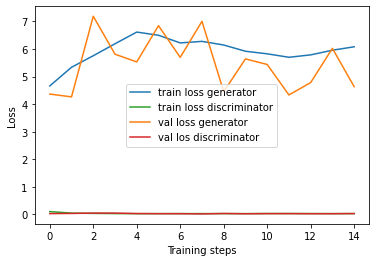

In [64]:
discriminator = Discriminator()
generator = Generator()
loss = tf.keras.losses.BinaryCrossentropy()
   
epochs = 15

gen_vis = training_loop(generator, discriminator, train_ds, test_ds, epochs)

In [70]:
# sample from the generated images
images = []
for i, batch in enumerate(gen_vis):
    if i%math.ceil(len(gen_vis)/32) == 0:
        images.append(tf.reshape(batch[0], [28,28]))

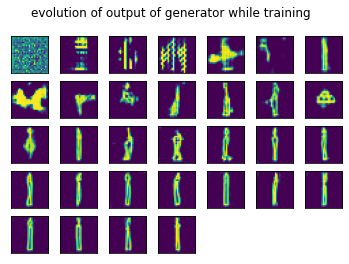

In [71]:
# plot the sampled images from training
for i in range(len(images)):
    plt.subplot(5,7,i+1)
    plt.imshow(images[i])
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)
plt.suptitle("evolution of output of generator while training")
plt.show()